# Working with VLMs (including Gemini Embodied Reasoning)


For this colab you will need a GenAI API key which you should have from the [Lab Setup Guide](https://www.mena.ml/program/lab-setup-guide#h.6mdws1pl8636). If you do not have an API key then please follow the instructions to get a key in the [Lab Setup Guide](https://www.mena.ml/program/lab-setup-guide#h.6mdws1pl8636). Once you have the API key then paste it into text box **MY_API_KEY**.

In [ ]:
# @title Setup Model Client with API Key
from google import genai
from google.genai import types

MY_API_KEY = ""  # @param {type:"string", isTemplate: true}
MODEL_NAME = "gemini-3-flash-preview" # @param ["gemini-3-flash-preview", "gemini-robotics-er-1.5-preview"] {isTemplate: true}
PROMPT = "Explain how a VLM works in a few words." # @param ["Explain how a VLM words.", "Explain how a VLM works in a few words."] {isTemplate: true}

client = genai.Client(api_key=MY_API_KEY)

response = client.models.generate_content(
    model=MODEL_NAME,
    contents=PROMPT,
)

print(response.text)

It translates images into "visual tokens" so a language model can understand and discuss them.


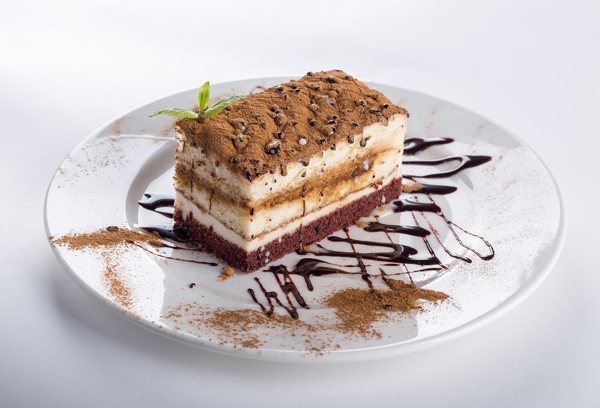

Image loaded. Size: (600, 408)


In [ ]:
# @title Download Sample Image
# Downloading a sample image for testing
from PIL import Image, ImageDraw, ImageFont
import requests
from io import BytesIO

image_url = "https://storage.googleapis.com/generativeai-downloads/images/cake.jpg" # Using a generic complex scene or replace with your own
response = requests.get(image_url)
image_bytes = response.content
img = Image.open(BytesIO(image_bytes))

# Resize for easier viewing in Colab
img.thumbnail((600, 600))
display(img)
print(f"Image loaded. Size: {img.size}")

In [ ]:
#@title Visualize Function visualize_response(image, response_text, mode="point")

import json
import numpy as np

# @markdown **Function:** `visualize_response`
# @markdown
# @markdown Parses a JSON string containing normalized spatial data (points or bounding boxes)
# @markdown and visualizes the data by drawing directly onto a copy of the provided PIL image.
# @markdown
# @markdown This function is designed to handle the standard output of Gemini Robotics models,
# @markdown automatically stripping Markdown code fences (e.g., ` ```json `) before parsing.
# @markdown It converts normalized coordinates (0-1000) into absolute pixel coordinates
# @markdown based on the input image dimensions.
# @markdown
# @markdown **Args:**
# @markdown * `image` (*PIL.Image.Image*):
# @markdown   The source image object. This image is copied before drawing, so the
# @markdown   original instance remains unmodified.
# @markdown * `response_text` (*str*):
# @markdown   The raw text output from the model containing a JSON array.
# @markdown   Expected structures:
# @markdown   - Point Mode: `[{"point": [y, x], "label": "name"}, ...]`
# @markdown   - Box Mode: `[{"box_2d": [ymin, xmin, ymax, xmax], "label": "name"}, ...]`
# @markdown * `mode` (*str*, optional):
# @markdown   The type of visualization to render. Defaults to "point".
# @markdown   - `'point'`: Expects "point" keys with [y, x] normalized coords.
# @markdown     Draws a red circle with a white outline and adjacent label text.
# @markdown   - `'box'`: Expects "box_2d" keys with [ymin, xmin, ymax, xmax] normalized coords.
# @markdown     Draws a green bounding box with label text above the top-left corner.
# @markdown
# @markdown **Returns:**
# @markdown * `None`:
# @markdown   The function displays the annotated image directly (using `display()`
# @markdown   for Jupyter/Colab environments). If JSON parsing fails, it prints
# @markdown   an error message instead of crashing.
def visualize_response(image, response_text, mode="point"):
    """
    Parses JSON output from Gemini and draws it on the image.
    mode: 'point' for single dots, 'box' for bounding boxes.
    """
    try:
        # Clean up code blocks if model returns markdown
        clean_text = response_text.replace("```json", "").replace("```", "").strip()
        data = json.loads(clean_text)
    except json.JSONDecodeError:
        print("Error parsing JSON:", response_text)
        return

    draw_img = image.copy()
    draw = ImageDraw.Draw(draw_img)
    width, height = draw_img.size

    for item in data:
        label = item.get("label", "Object")

        if mode == "point" and "point" in item:
            # Normalized [y, x] -> [x, y] pixel coords
            norm_y, norm_x = item["point"]
            abs_x = int((norm_x / 1000) * width)
            abs_y = int((norm_y / 1000) * height)

            # Draw point and text
            r = 5
            draw.ellipse((abs_x-r, abs_y-r, abs_x+r, abs_y+r), fill="red", outline="white")
            draw.text((abs_x + 10, abs_y), label, fill="red")

        elif mode == "box" and "box_2d" in item:
            # Normalized [ymin, xmin, ymax, xmax]
            ymin, xmin, ymax, xmax = item["box_2d"]
            abs_ymin = int((ymin / 1000) * height)
            abs_xmin = int((xmin / 1000) * width)
            abs_ymax = int((ymax / 1000) * height)
            abs_xmax = int((xmax / 1000) * width)

            draw.rectangle([abs_xmin, abs_ymin, abs_xmax, abs_ymax], outline="green", width=3)
            draw.text((abs_xmin, abs_ymin - 10), label, fill="green")

    display(draw_img)

print("✅ Visualization helper ready.")

✅ Visualization helper ready.


Raw Output:
 ```json
[
  {"point": [419, 484], "label": "tiramisu"},
  {"point": [245, 335], "label": "mint leaf"},
  {"point": [521, 578], "label": "chocolate base"},
  {"point": [306, 506], "label": "cacao powder"},
  {"point": [376, 453], "label": "chocolate chips"},
  {"point": [600, 706], "label": "chocolate sauce"},
  {"point": [757, 626], "label": "cinnamon powder"},
  {"point": [483, 397], "label": "tiramisu layers"},
  {"point": [487, 503], "label": "cream layer"},
  {"point": [500, 500], "label": "dessert"}
]
```


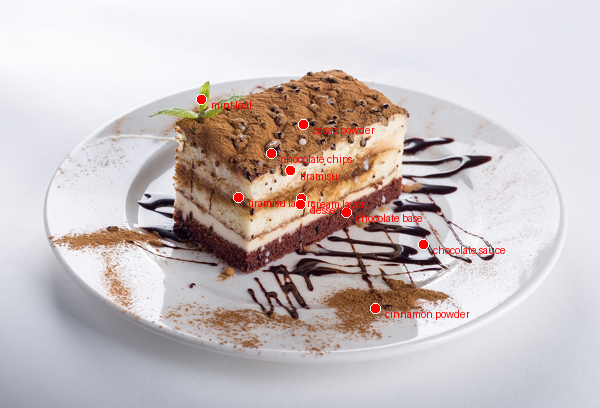

In [ ]:
PROMPT_POINTING = """
Point to no more than 10 items in the image.
The label returned should be an identifying name for the object detected.
The answer should follow the json format: [{"point": <point>, "label": <label1>}, ...].
The points are in [y, x] format normalized to 0-1000.
"""

response = client.models.generate_content(
    model="gemini-robotics-er-1.5-preview",
    contents=[
        types.Part.from_bytes(data=image_bytes, mime_type='image/jpeg'),
        PROMPT_POINTING
    ],
    config=types.GenerateContentConfig(
        temperature=0.5,
        thinking_config=types.ThinkingConfig(thinking_budget=0) # Low latency for perception
    )
)

print("Raw Output:\n", response.text)
visualize_response(img, response.text, mode="point")

### Requesting a Trajectory of Points.

Imagine a robot arm needs to decorate the cake.
Place 10 points that trace the outer edge of the cake.
The points should be labeled by order of the trajectory, from '0' (start) to '9' (end).
The answer should follow the json format: [{"point": <point>, "label": <label1>}, ...].
The points are in [y, x] format normalized to 0-1000.

In [ ]:
# We ask the model to trace a path along a specific object or between objects
PROMPT_TRAJECTORY = "" # @param {type:"string", isTemplate: true}

PROMPT_TRAJECTORY_SOLUTION = """
Imagine a robot arm needs to decorate the cake.
Place 10 points that trace the outer edge of the cake.
The points should be labeled by order of the trajectory, from '0' (start) to '9' (end).
The answer should follow the json format: [{"point": <point>, "label": <label1>}, ...].
The points are in [y, x] format normalized to 0-1000.
"""

assert PROMPT_TRAJECTORY != "", "You need to create a prompt. \nIf stuck see PROMPT_TRAJECTORY_SOLUTION in 'Show Code'"

response = client.models.generate_content(
    model="gemini-robotics-er-1.5-preview",
    contents=[
        types.Part.from_bytes(data=image_bytes, mime_type='image/jpeg'),
        PROMPT_TRAJECTORY
    ],
    config=types.GenerateContentConfig(temperature=0.5)
)

print("Raw Output:\n", response.text)
visualize_response(img, response.text, mode="point")

AssertionError: You need to create a prompt. 
If stuck see PROMPT_TRAJECTORY_SOLUTION in 'Show Code'

### Asking a question that requires understanding relationships, not just detection.

Get creative. Ask where to cut the cake and what to avoid.

**REMEMBER** Ask for the answer to be formatted in json!

If this gets too hard then get a hint from the AssertionError when passing in an empty prompt.

In [ ]:
PROMPT_REASONING = "" # @param {type:"string", isTemplate: true}
PROMPT_REASONING_SOLUTION = """
I want to cut a slice of this cake.
Point to the specific location where I should insert the knife to start cutting.
Also label any obstacles I should avoid.
The answer should follow the json format: [{"point": <point>, "label": <label1>}, ...].
The points are in [y, x] format normalized to 0-1000.
"""

assert PROMPT_REASONING != "", "You need to create a prompt. \nIf stuck see PROMPT_REASONING_SOLUTION in 'Show Code'"


response = client.models.generate_content(
    model="gemini-robotics-er-1.5-preview",
    contents=[
        types.Part.from_bytes(data=image_bytes, mime_type='image/jpeg'),
        PROMPT_REASONING
    ],
    config=types.GenerateContentConfig(temperature=0.5)
)

print("Raw Output:\n", response.text)
visualize_response(img, response.text, mode="point")

AssertionError: You need to create a prompt. 
If stuck see PROMPT_REASONING_SOLUTION in 'Show Code'

Task Context Loaded:


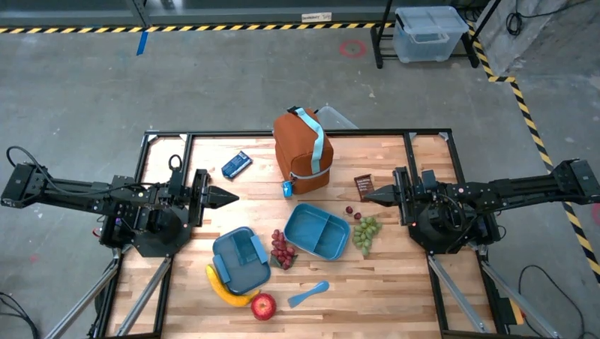

Sending Prompt:

Imagine a robot arm needs to pick up grages with right gripper.
Place 10 points that trace the path for the selected gripper to pick up grages with right gripper.
The points should be labeled by order of the trajectory, from '0' (start) to '9' (end).
The answer should follow the json format: [{"point": <point>, "label": <label1>}, ...].
The points are in [y, x] format normalized to 0-1000.


Raw Output:
 ```json
[
  {"point": [580, 750], "label": "0"},
  {"point": [590, 720], "label": "1"},
  {"point": [600, 690], "label": "2"},
  {"point": [610, 660], "label": "3"},
  {"point": [620, 640], "label": "4"},
  {"point": [630, 625], "label": "5"},
  {"point": [635, 615], "label": "6"},
  {"point": [640, 610], "label": "7"},
  {"point": [645, 605], "label": "8"},
  {"point": [650, 600], "label": "9"}
]
```


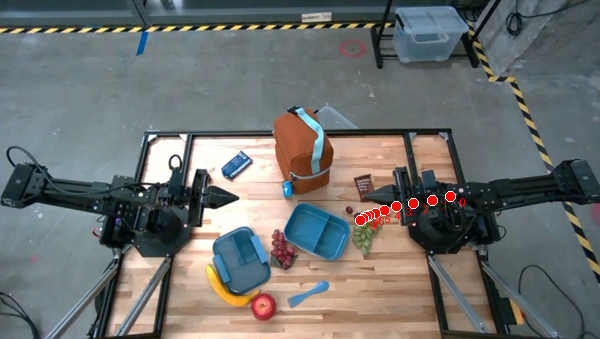

In [ ]:
# 1. Load the specific "Packing Lunch" image
image_url = "https://ai.google.dev/static/gemini-api/docs/images/robotics/packing-lunch.png"
response = requests.get(image_url)
lunch_image_bytes = response.content
img_lunch = Image.open(BytesIO(lunch_image_bytes))

# Resize for easier viewing
img_lunch.thumbnail((600, 600))
print("Task Context Loaded:")
display(img_lunch)

# 2. Define the specific sub-task
SUB_TASK = "pick up grages with right gripper"

# 3. Define the Prompt Template
# Note: We use double braces {{ }} for the JSON part to escape them for .format()
PROMPT_GRIPPER_TRAJECTORY = """
Imagine a robot arm needs to {0}.
Place 10 points that trace the path for the selected gripper to {0}.
The points should be labeled by order of the trajectory, from '0' (start) to '9' (end).
The answer should follow the json format: [{{"point": <point>, "label": <label1>}}, ...].
The points are in [y, x] format normalized to 0-1000.
"""


# 4. Insert the sub-task into the prompt template
formatted_prompt = PROMPT_GRIPPER_TRAJECTORY.format(SUB_TASK)
print(f"Sending Prompt:\n{formatted_prompt}")

# 5. Generate Content
response = client.models.generate_content(
    model="gemini-robotics-er-1.5-preview",
    contents=[
        types.Part.from_bytes(data=lunch_image_bytes, mime_type='image/png'),
        formatted_prompt
    ],
    config=types.GenerateContentConfig(temperature=0.5)
)

print("\nRaw Output:\n", response.text)

# 6. Visualize the specific trajectory
visualize_response(img_lunch, response.text, mode="point")

```json
[
  {"box_2d": [172, 287, 668, 684], "label": "tiramisu"},
  {"box_2d": [201, 250, 301, 408], "label": "mint leaf"},
  {"box_2d": [190, 71, 878, 939], "label": "plate"}
]
```


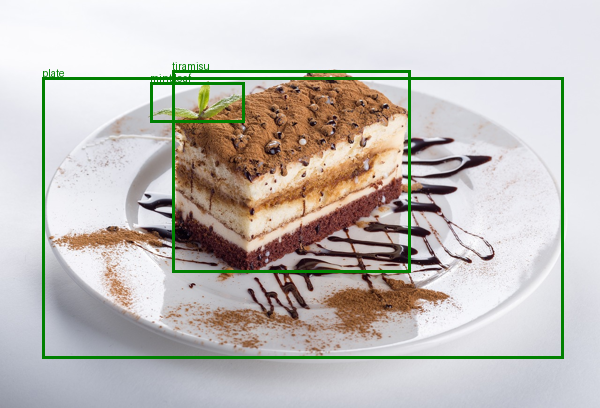

In [ ]:
prompt = """
      Return bounding boxes as a JSON array with labels. Never return masks
      or code fencing. Limit to 25 objects. Include as many objects as you
      can identify on the table.
      If an object is present multiple times, name them according to their
      unique characteristic (colors, size, position, unique characteristics, etc..).
      The format should be as follows: [{"box_2d": [ymin, xmin, ymax, xmax],
      "label": <label for the object>}] normalized to 0-1000. The values in
      box_2d must only be integers
      """

response = client.models.generate_content(
  model="gemini-robotics-er-1.5-preview",
  contents=[
    types.Part.from_bytes(
      data=image_bytes,
      mime_type='image/jpeg',
    ),
    prompt
  ],
  config = types.GenerateContentConfig(
      temperature=0.5,
      thinking_config=types.ThinkingConfig(thinking_budget=0)
  )
)

print(response.text)
visualize_response(img, response.text, mode="box")

# Ask model rotate stool.png

For the next part you will need to upload the stool.png file into the colab. The answer for this will help with the second part of the lab session.

In [ ]:
PROMPT = """
          In the image what do you see and how should it be rotated to be virtically upright if z direction was pointing upwards?
          The answer should follow the json format: [{"rotation": <rotation>,
          "label": <label1>}, ...]. The rotation should be euler angles in radians with 2 decimal places [rotate_x, rotate_y, rotate_z] format
          normalized between 0 and 2pi.
        """

# Load your image
with open("stool.png", 'rb') as f:
    image_bytes = f.read()

image_response = client.models.generate_content(
    model="gemini-robotics-er-1.5-preview",
    contents=[
        types.Part.from_bytes(
            data=image_bytes,
            mime_type='image/png',
        ),
        PROMPT
    ],
    config = types.GenerateContentConfig(
        temperature=0.05,
        thinking_config=types.ThinkingConfig(thinking_budget=0)
    )
)

print(image_response.text)

FileNotFoundError: [Errno 2] No such file or directory: 'stool.png'

Did you find Gemini Emodied Reasoning fun to work with. Learn more at [ai.google.dev](https://ai.google.dev/gemini-api/docs/robotics-overview).